In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.widgets import *
import numpy as np
from fastai.callbacks.hooks import *
torch.cuda.current_device()#個人PCのエラー対策用

0

# Delete files that are not images

In [3]:
path=r"UTKFace\\"

In [4]:
verify_images("path", delete=True, max_size=500)

 [age]_[gender]_[race]_[date&time].jpg

In [5]:
fnames=get_image_files(path);fnames[:5]

[WindowsPath('C:/Users/12829/Desktop/deepblue/age prediction/UTKFace.tar/UTKFace/100_0_0_20170112213500903.jpg.chip.jpg'),
 WindowsPath('C:/Users/12829/Desktop/deepblue/age prediction/UTKFace.tar/UTKFace/100_0_0_20170112215240346.jpg.chip.jpg'),
 WindowsPath('C:/Users/12829/Desktop/deepblue/age prediction/UTKFace.tar/UTKFace/100_1_0_20170110183726390.jpg.chip.jpg'),
 WindowsPath('C:/Users/12829/Desktop/deepblue/age prediction/UTKFace.tar/UTKFace/100_1_0_20170112213001988.jpg.chip.jpg'),
 WindowsPath('C:/Users/12829/Desktop/deepblue/age prediction/UTKFace.tar/UTKFace/100_1_0_20170112213303693.jpg.chip.jpg')]

In [6]:
#age
np.random.seed(2)
pat = r'(\d+)_'

# Create DataBunch

In [7]:
data = ImageDataBunch.from_name_re(path, 
                                   fnames, 
                                   pat, 
                                   ds_tfms=get_transforms(), 
                                   size=64
                                   )
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (18940 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
100,100,100,100,100
Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Valid: LabelList (4735 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
48,57,1,60,27
Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Test: None

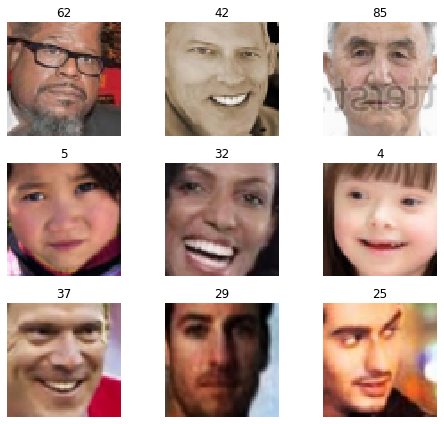

In [8]:
data.show_batch(rows=3,figsize=(7,6))

In [8]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

In [9]:
#ラベル
print(data.classes)
#ラベル数、訓練データ数、検証データ数
data.c, len(data.train_ds), len(data.valid_ds)

['1', '10', '100', '101', '103', '105', '11', '110', '115', '116', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '95', '96', '99']


(103, 18940, 4735)

In [10]:
def conv(ni,nf,ks): return nn.Sequential(nn.Conv2d(ni,nf,ks,stride=1),nn.BatchNorm2d(32),nn.ReLU())

# Loss Function

In [11]:
class TotalLoss(nn.Module):
    def __init__(self):
        super(TotalLoss, self).__init__()
     #mae+kl   
    def forward(self, output, label):
        return torch.mean(torch.abs(output-label))+((output*torch.log(output/label)).sum()) 

# Model

In [12]:
model= nn.Sequential(
    conv(3,32,3),
    nn.AvgPool2d(2,2),
    conv(32,32,3),
    nn.AvgPool2d(2,2),
    conv(32,32,3),
    nn.AvgPool2d(2,2),
    conv(32,32,3),
    nn.Conv2d(32,32,1),
    #nn.Conv2d(32,12,4),
    #nn.Conv2d(12,1,1),
    Flatten()
)

# Create Learner

In [13]:
#customize
learn = Learner(data, model,metrics=error_rate)
learn.loss = TotalLoss()

In [14]:
learn.split(lambda m: (m[0][0], m[6]))

Learner(data=ImageDataBunch;

Train: LabelList (18940 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
100,100,100,100,100
Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Valid: LabelList (4735 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
48,57,1,60,27
Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): AvgPool2d(kernel_size=2,

In [15]:
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
   (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): ReLU()
   (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
   (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
   (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU()
   (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
 ),
 Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
   (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU()
   (3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
   (4): Flatten()
 )]

In [16]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 62, 62]         896        True      
______________________________________________________________________
BatchNorm2d          [32, 62, 62]         64         True      
______________________________________________________________________
ReLU                 [32, 62, 62]         0          False     
______________________________________________________________________
AvgPool2d            [32, 31, 31]         0          False     
______________________________________________________________________
Conv2d               [32, 29, 29]         9,248      True      
______________________________________________________________________
BatchNorm2d          [32, 29, 29]         64         True      
______________________________________________________________________
ReLU                 [32, 29, 29]         0          False     
___________________________________________________

In [17]:
xb = xb.cuda()
model(xb).shape

torch.Size([64, 512])

# Learning Rate

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


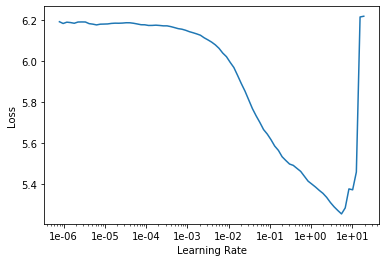

In [18]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

# Fine-tuning

In [19]:
learn.fit_one_cycle(5,slice(3e-2))

epoch,train_loss,valid_loss,error_rate,time
0,4.147784,4.067529,0.889335,01:58
1,3.987225,3.972230,0.877086,01:23
2,3.890885,3.834187,0.874762,01:25
3,3.782658,3.681288,0.861246,01:25
4,3.730968,3.650182,0.859768,01:24


In [20]:
learn.save('C3AE_age2')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


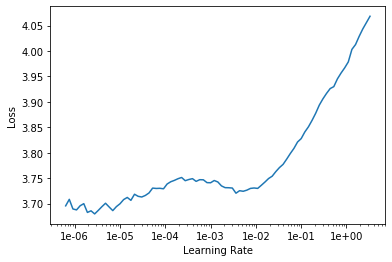

In [21]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

# Training

In [22]:
learn.fit_one_cycle(15, slice(3e-4,3e-3))

epoch,train_loss,valid_loss,error_rate,time
0,3.689526,3.645469,0.859556,01:25
1,3.696194,3.638949,0.859768,01:21
2,3.717692,3.629087,0.861246,01:22
3,3.677052,3.617941,0.857867,01:23
4,3.680464,3.603480,0.857233,01:22
5,3.667536,3.581614,0.855755,01:21
6,3.667239,3.583920,0.856389,01:22
7,3.628980,3.574749,0.853643,01:22
8,3.626817,3.554190,0.852587,01:22
9,3.611203,3.545739,0.855333,01:23


# Loss Rate

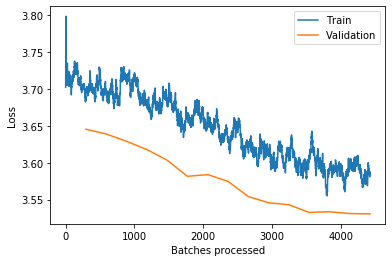

In [23]:
learn.recorder.plot_losses()

In [24]:
learn.save('C3AE_age2')

# Wrong Classification

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

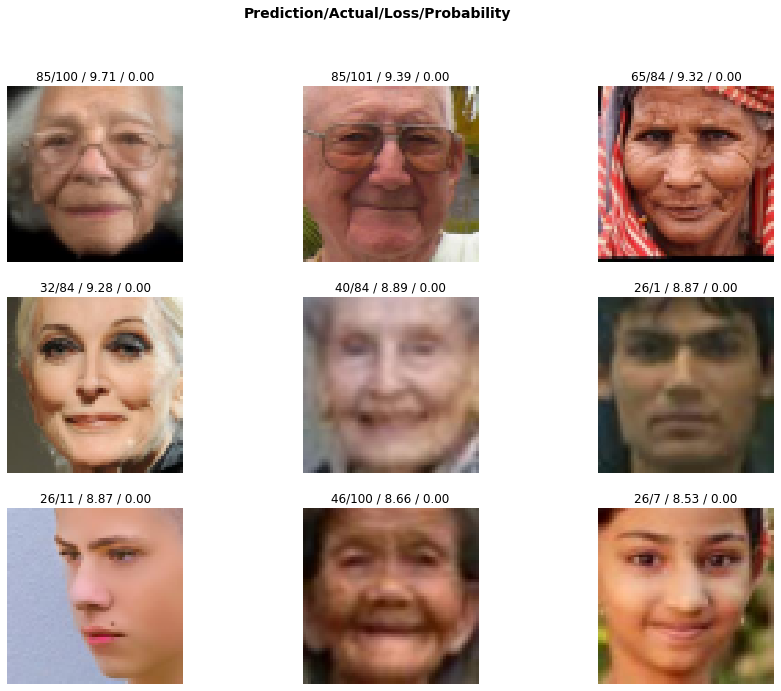

In [26]:
interp.plot_top_losses(9,figsize=(15,11))

# Test Image

In [27]:
img = open_image(r"HAONAN HU.jpg")

In [28]:
classes=data.classes

In [29]:
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=64).normalize(imagenet_stats)
learn = Learner(data2, model)
learn.load('C3AE_age2')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: C:\Users\12829\Desktop\deepblue\age prediction\UTKFace.tar\UTKFace;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): A

# Test Output

In [30]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category 31